## Import and Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/RL

import gym
import numpy as np
import utils.envs, utils.seed, utils.buffers, utils.torch, utils.common
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Constants
SEEDS = [1,2,3,4,5]
t = utils.torch.TorchHelper()
DEVICE = t.device
OBS_N = 4               # State space size
ACT_N = 2               # Action space size
MINIBATCH_SIZE = 64     # How many examples to sample per train step
GAMMA = 0.99            # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4    # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 25       # Train for these many epochs every time
BUFSIZE = 10000         # Replay buffer size
EPISODES = 300          # Total number of episodes to learn over
TEST_EPISODES = 1       # Test episodes after every train episode
HIDDEN = 512            # Hidden nodes
TARGET_UPDATE_FREQ = 10 # Target network update frequency
STARTING_EPSILON = 1.0  # Starting epsilon
STEPS_MAX = 20000       # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01      # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None
LAMBDA = 10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/RL'
/content/drive/MyDrive/RL


## DQN


Seed=1
Training:


R25(171.72): 100%|██████████| 300/300 [01:27<00:00,  3.42it/s]


Training finished!
Seed=2
Training:


R25(185.48): 100%|██████████| 300/300 [01:30<00:00,  3.31it/s]


Training finished!
Seed=3
Training:


R25(189.92): 100%|██████████| 300/300 [01:28<00:00,  3.41it/s]


Training finished!
Seed=4
Training:


R25(174.92): 100%|██████████| 300/300 [01:28<00:00,  3.40it/s]


Training finished!
Seed=5
Training:


R25(189.6): 100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


Training finished!


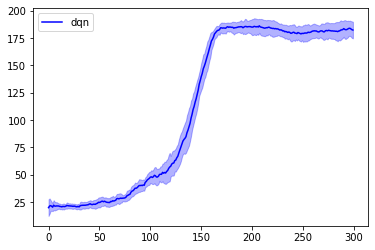

In [ ]:
# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer 
def create_everything(seed):

    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    env.seed(seed)
    test_env = gym.make("CartPole-v0")
    test_env.seed(10+seed)                  
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT

# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)

# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q
    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor

    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a) 
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()

    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action


# Update networks
def update_networks(epi, buf, Q, Qt, OPT):
    
    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim = 1).values

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

# Play episodes
# Training function
def train(seed):

    global EPSILON, Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy, buf)

        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS): 
                update_networks(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()
    test_env.close()

    return last25testRs

# Plot mean curve and (mean-std, mean+std) curve with some transparency
# Clip the curves to be between 0, 200
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)

if __name__ == "__main__":

    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, 'b', 'dqn')
    plt.legend(loc='best')
    plt.savefig('dqn.png')
    plt.show()


## Soft QN


In [ ]:
Q = None
# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer 
def create_everything(seed):

    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    env.seed(seed)
    test_env = gym.make("CartPole-v0")
    test_env.seed(10+seed)                  
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT


# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)


# Create softmax policy
def policy_SQN(env, obs):

    global Q
    obs = t.f(obs).view(-1, OBS_N)
    qvalues = Q(obs)
    
    # Sample actions with the probability of Softmax of Q
    action = torch.multinomial(torch.nn.Softmax(dim=-1)(qvalues / LAMBDA), 
                  num_samples=1, replacement=True).item()
    
    return action


# Update networks
def update_networks_SQN(epi, buf, Q, Qt, OPT):

    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)

    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get soft_max_a' Qt(s', a') for every (s') in the minibatch
    q2values = LAMBDA * torch.logsumexp(Qt(S2) / LAMBDA, dim = 1)

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

# Play episodes
# Training function
def train_SQN(seed):

    global Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy_SQN, buf)

        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS): 
                update_networks_SQN(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy_SQN, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()
    test_env.close()

    return last25testRs

# Plot mean curve and (mean-std, mean+std) curve with some transparency
# Clip the curves to be between 0, 200 
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)


## Soft Actor critic

In [ ]:
Q = None
# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer 
def create_everything_SAC(seed):

    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    env.seed(seed)
    test_env = gym.make("CartPole-v0")
    test_env.seed(10+seed)
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Pi = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N), torch.nn.Softmax()
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    PiOPT = torch.optim.Adam(Pi.parameters(), lr = LEARNING_RATE)

    return env, test_env, buf, Q, Qt, OPT, Pi, PiOPT


# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)


# Create policy
def policy_SAC(env, obs):

    global Pi
    obs = t.f(obs).view(-1, OBS_N)
    pvalues = Pi(obs)

    # Sample actions with the probability of Pi(s)
    action = torch.multinomial(pvalues, num_samples=1, replacement=True).item()

    return action


# Update networks
def update_networks_SAC(epi, buf, Q, Qt, OPT, Pi, PiOPT):

    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Sample action for the next action
    A2 = torch.multinomial(Pi(S2), num_samples=1, replacement=True).squeeze()
    # Get Q Values for the next state-action pair from target Q and also the entropy
    q2values = Qt(S2).gather(1, A2.view(-1, 1)).squeeze()
    pi_entropy = torch.distributions.Categorical(probs = Pi(S2)).entropy()

    # Calculate the target
    targets = R + GAMMA * (q2values + LAMBDA * pi_entropy) * (1-D)

    # Detach y since it is the target. Target values should be kept fixed
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Pi update
    val = Pi(S)
    target2 = torch.nn.Softmax(dim=-1)(Qt(S) / LAMBDA)
    pi_loss = torch.nn.functional.kl_div(target2.log(), val)

    # Backpropagation
    PiOPT.zero_grad()
    pi_loss.backward()
    PiOPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

# Play episodes
# Training function
def train_SAC(seed):

    global Q, Pi
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer, Pi
    env, test_env, buf, Q, Qt, OPT, Pi, PiOPT = create_everything_SAC(seed)

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy_SAC, buf)

        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS):
                update_networks_SAC(epi, buf, Q, Qt, OPT, Pi, PiOPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy_SAC, render=False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()
    test_env.close()

    return last25testRs

# Plot mean curve and (mean-std, mean+std) curve with some transparency
# Clip the curves to be between 0, 200 
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)

## DQN, SQN, SAC Comparison 

Seed=1
Training:


R25(174.88): 100%|██████████| 300/300 [03:18<00:00,  1.51it/s]


Training finished!
Seed=2
Training:


R25(172.12): 100%|██████████| 300/300 [03:21<00:00,  1.49it/s]


Training finished!
Seed=3
Training:


R25(185.16): 100%|██████████| 300/300 [03:20<00:00,  1.49it/s]


Training finished!
Seed=4
Training:


R25(179.32): 100%|██████████| 300/300 [03:17<00:00,  1.52it/s]


Training finished!
Seed=5
Training:


R25(191.12): 100%|██████████| 300/300 [03:24<00:00,  1.46it/s]


Training finished!
Seed=1
Training:


R25(187.36): 100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


Training finished!
Seed=2
Training:


R25(191.12): 100%|██████████| 300/300 [01:40<00:00,  2.99it/s]


Training finished!
Seed=3
Training:


R25(182.08): 100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


Training finished!
Seed=4
Training:


R25(168.36): 100%|██████████| 300/300 [01:36<00:00,  3.12it/s]


Training finished!
Seed=5
Training:


R25(180.2): 100%|██████████| 300/300 [01:36<00:00,  3.11it/s]


Training finished!
Seed=1
Training:


R25(171.72): 100%|██████████| 300/300 [01:25<00:00,  3.51it/s]


Training finished!
Seed=2
Training:


R25(185.48): 100%|██████████| 300/300 [01:27<00:00,  3.41it/s]


Training finished!
Seed=3
Training:


R25(189.92): 100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


Training finished!
Seed=4
Training:


R25(174.92): 100%|██████████| 300/300 [01:28<00:00,  3.38it/s]


Training finished!
Seed=5
Training:


R25(189.6): 100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


Training finished!


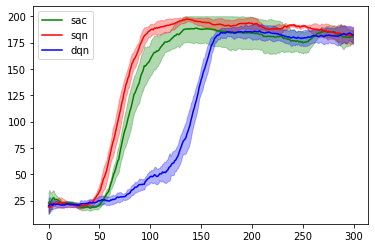

In [ ]:
if __name__ == "__main__":

    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train_SAC(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, 'g', 'sac')

    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train_SQN(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, 'r', 'sqn')
    
    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, 'b', 'dqn')
    
    plt.legend(loc='best')
    plt.savefig('agg.png')
    plt.show()


## Sweep lambda in SQN

Seed=1
Training:


R25(196.88): 100%|██████████| 300/300 [01:41<00:00,  2.96it/s]


Training finished!
Seed=2
Training:


R25(194.88): 100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


Training finished!
Seed=3
Training:


R25(179.56): 100%|██████████| 300/300 [01:40<00:00,  3.00it/s]


Training finished!
Seed=4
Training:


R25(186.56): 100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


Training finished!
Seed=5
Training:


R25(174.16): 100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


Training finished!
Seed=1
Training:


R25(187.36): 100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


Training finished!
Seed=2
Training:


R25(191.12): 100%|██████████| 300/300 [01:38<00:00,  3.04it/s]


Training finished!
Seed=3
Training:


R25(182.08): 100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


Training finished!
Seed=4
Training:


R25(168.36): 100%|██████████| 300/300 [01:39<00:00,  3.02it/s]


Training finished!
Seed=5
Training:


R25(180.2): 100%|██████████| 300/300 [01:38<00:00,  3.05it/s]


Training finished!
Seed=1
Training:


R25(199.68): 100%|██████████| 300/300 [01:35<00:00,  3.15it/s]


Training finished!
Seed=2
Training:


R25(190): 100%|██████████| 300/300 [01:34<00:00,  3.19it/s]


Training finished!
Seed=3
Training:


R25(190.2): 100%|██████████| 300/300 [01:31<00:00,  3.27it/s]


Training finished!
Seed=4
Training:


R25(182.52): 100%|██████████| 300/300 [01:34<00:00,  3.18it/s]


Training finished!
Seed=5
Training:


R25(196.24): 100%|██████████| 300/300 [01:32<00:00,  3.25it/s]


Training finished!
Seed=1
Training:


R25(184.44): 100%|██████████| 300/300 [01:21<00:00,  3.66it/s]


Training finished!
Seed=2
Training:


R25(172.76): 100%|██████████| 300/300 [01:24<00:00,  3.56it/s]


Training finished!
Seed=3
Training:


R25(199.4): 100%|██████████| 300/300 [01:25<00:00,  3.52it/s]


Training finished!
Seed=4
Training:


R25(187.08): 100%|██████████| 300/300 [01:25<00:00,  3.53it/s]


Training finished!
Seed=5
Training:


R25(174.2): 100%|██████████| 300/300 [01:25<00:00,  3.51it/s]


Training finished!


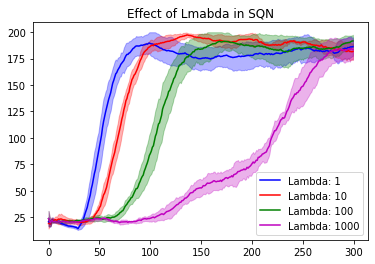

In [ ]:
plot_colors = {1: 'b', 10: 'r', 100: 'g', 1000: 'm'}

# Go over different lambda values
for LAMBDA in [1, 10, 100, 1000]:
    curves = []
    for seed in SEEDS:
        curves += [train_SQN(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, plot_colors[LAMBDA], "Lambda: {}".format(LAMBDA))

plt.title("Effect of Lmabda in SQN")
plt.legend(loc='best')
plt.savefig('SQN_LAMBA.png')
plt.show()

## Sweep lamba in SAC

Seed=1
Training:


R25(186.04): 100%|██████████| 300/300 [03:19<00:00,  1.50it/s]


Training finished!
Seed=2
Training:


R25(197.44): 100%|██████████| 300/300 [03:21<00:00,  1.49it/s]


Training finished!
Seed=3
Training:


R25(185.04): 100%|██████████| 300/300 [03:23<00:00,  1.47it/s]


Training finished!
Seed=4
Training:


R25(187.84): 100%|██████████| 300/300 [03:20<00:00,  1.50it/s]


Training finished!
Seed=5
Training:


R25(186.52): 100%|██████████| 300/300 [03:23<00:00,  1.48it/s]


Training finished!
Seed=1
Training:


R25(174.88): 100%|██████████| 300/300 [03:21<00:00,  1.49it/s]


Training finished!
Seed=2
Training:


R25(172.12): 100%|██████████| 300/300 [03:19<00:00,  1.50it/s]


Training finished!
Seed=3
Training:


R25(185.16): 100%|██████████| 300/300 [03:24<00:00,  1.47it/s]


Training finished!
Seed=4
Training:


R25(179.32): 100%|██████████| 300/300 [03:20<00:00,  1.50it/s]


Training finished!
Seed=5
Training:


R25(191.12): 100%|██████████| 300/300 [03:19<00:00,  1.50it/s]


Training finished!
Seed=1
Training:


R25(190.2): 100%|██████████| 300/300 [03:17<00:00,  1.52it/s]


Training finished!
Seed=2
Training:


R25(192.56): 100%|██████████| 300/300 [03:22<00:00,  1.48it/s]


Training finished!
Seed=3
Training:


R25(198.76): 100%|██████████| 300/300 [03:18<00:00,  1.51it/s]


Training finished!
Seed=4
Training:


R25(186.12): 100%|██████████| 300/300 [03:15<00:00,  1.54it/s]


Training finished!
Seed=5
Training:


R25(188.12): 100%|██████████| 300/300 [03:16<00:00,  1.52it/s]


Training finished!
Seed=1
Training:


R25(178.56): 100%|██████████| 300/300 [03:05<00:00,  1.62it/s]


Training finished!
Seed=2
Training:


R25(183.24): 100%|██████████| 300/300 [03:06<00:00,  1.61it/s]


Training finished!
Seed=3
Training:


R25(199.8): 100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


Training finished!
Seed=4
Training:


R25(183.44): 100%|██████████| 300/300 [03:04<00:00,  1.63it/s]


Training finished!
Seed=5
Training:


R25(193.4): 100%|██████████| 300/300 [03:06<00:00,  1.61it/s]


Training finished!


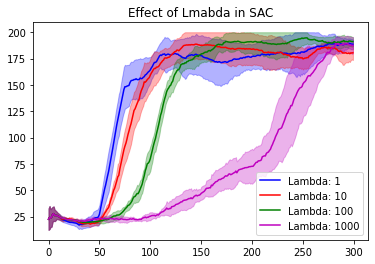

In [ ]:
plot_colors = {1: 'b', 10: 'r', 100: 'g', 1000: 'm'}

# Go over different lambda values
for LAMBDA in [1, 10, 100, 1000]:
    curves = []
    for seed in SEEDS:
        curves += [train_SAC(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, plot_colors[LAMBDA], "Lambda: {}".format(LAMBDA))
 
plt.title("Effect of Lmabda in SAC")
plt.legend(loc='best')
plt.savefig('SAC_LAMBA.png')
plt.show()

### Explanation
*** Explain the results. Discuss how different properties of each algorithm influence the number of steps before the pole falls. Discuss also the impact of the temperature lambda.***


The results show that sqn slighlty outperforms sac, but sac significantly outperforms dqn. It demosterates the fact that adding entropy to the objective is useful. This is because by adding entropy, we tend to not giving higher chance of selection to a specific acton, and rather favor more randomness in action selection that as a result enables the agent to more explore. Therefore, we observe a fast convergence in sqn and sac. 

Here, sqn is outperforming sac. I did not expect it, but I guess it is related to the dynamics of this problem.

In the last two figures, we can observe that as the temerature increases, the performance drops. It is due to the fact that when the temperature is rather high, we de not prefer a good action all the time, and we have more chance of exploration. For this problem, a sequence a bad actions can easily instabilize the pole, in a way that it falls. So here more exploration has the serious cost of ending the game very early, and as we can see in the last two figures, as we increase the temperature, the convergence becomse too slow, and the agent will learn rather late.